## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

## Sigmoid Function

In [2]:
def sigmoid(x):
    out = np.empty_like(x)
    pos_mask = x >= 0
    neg_mask = ~pos_mask

    out[pos_mask] = 1 / (1 + np.exp(-x[pos_mask]))
    exp_x = np.exp(x[neg_mask])
    out[neg_mask] = exp_x / (1 + exp_x)

    return out

## RBF Kernel

In [3]:
def rbf_kernel(X1, X2, length_scale=1.0, sigma_f=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + \
             np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

## Laplace Approximation For GP

In [4]:
def laplace_approximation(X, y, kernel, length_scale=1.0, sigma_f=1.0, max_iter=20):
    K = kernel(X, X, length_scale, sigma_f)
    f = np.zeros(len(y))

    for _ in range(max_iter):
        pi = sigmoid(f)
        W = np.diag(pi * (1 - pi))
        z = np.dot(W, f) + (y - pi)
        B = np.eye(len(y)) + np.dot(np.dot(W**0.5, K), W**0.5)
        L = np.linalg.cholesky(B)
        a = z - np.dot(K, np.dot(W, f))
        f = np.dot(K, a)
        
    pi = sigmoid(f)
    W = np.diag(pi * (1 - pi))
    return f, K, W, L

## Prediction with GP

In [5]:
def predict_fixed(X_train, y_train, X_test, kernel, f_hat, K, W, L, length_scale=1.0, sigma_f=1.0):
    K_s = kernel(X_train, X_test, length_scale, sigma_f)
    K_ss_diag = np.ones(X_test.shape[0]) * sigma_f**2

    sqrtW = np.diag(np.sqrt(np.diag(W)))
    v = np.linalg.solve(L, sqrtW @ K_s)
    pred_mean = K_s.T @ np.linalg.solve(K, f_hat)
    pred_var = K_ss_diag - np.sum(v**2, axis=0)

    pred_var = np.clip(pred_var, 1e-6, None)

    pred_prob = sigmoid(pred_mean / np.sqrt(1 + pred_var))
    return pred_prob

## Generate Data

In [6]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0,
                           n_informative=2, random_state=42,
                           n_clusters_per_class=1)
y = 2*y - 1  # Convert labels from {0, 1} to {-1, 1}

## Train - Test Split

In [7]:
X_train, X_test_split, y_train, y_test_split = train_test_split(X, y, test_size=0.3, random_state=42)

## Plotting

In [8]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
X_grid = np.c_[xx.ravel(), yy.ravel()]

## Testing Different Hyperparameters

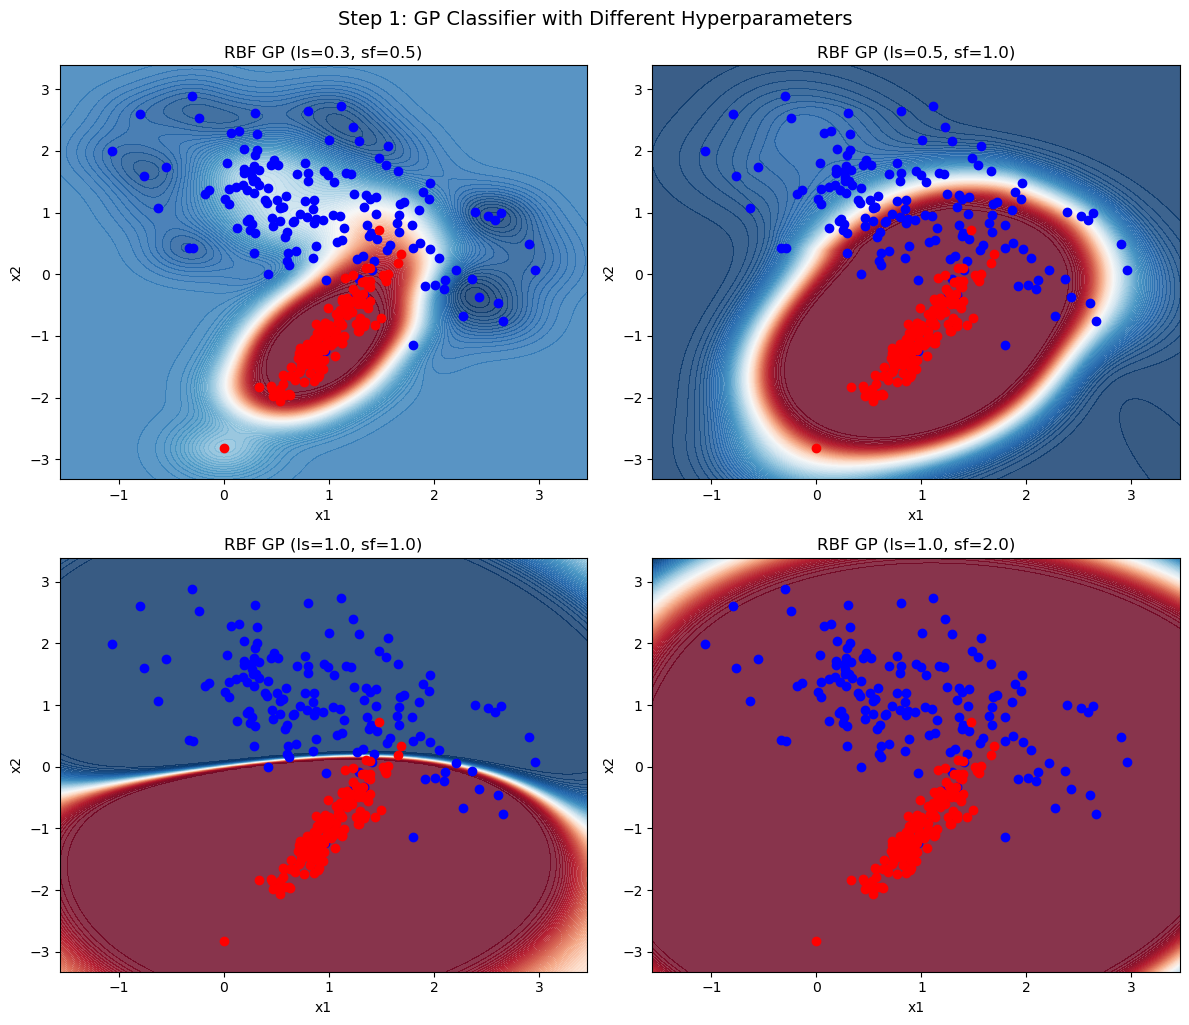

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
param_grid = [(0.3, 0.5), (0.5, 1.0), (1.0, 1.0), (1.0, 2.0)]

for ax, (ls, sf) in zip(axs.ravel(), param_grid):
    f_hat, K, W, L = laplace_approximation(X, y, rbf_kernel, ls, sf)
    Z = predict_fixed(X, y, X_grid, rbf_kernel, f_hat, K, W, L, ls, sf).reshape(xx.shape)
    ax.contourf(xx, yy, Z, levels=100, cmap='RdBu', alpha=0.8)
    ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='b', label='+1')
    ax.scatter(X[y == -1][:, 0], X[y == -1][:, 1], c='r', label='-1')
    ax.set_title(f"RBF GP (ls={ls}, sf={sf})")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

plt.tight_layout()
plt.suptitle("Step 1: GP Classifier with Different Hyperparameters", fontsize=14, y=1.02)
plt.show()

## SVM Grid Search

In [10]:
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}
svm_grid = GridSearchCV(SVC(probability=True), svm_param_grid, cv=5, scoring='accuracy')
svm_grid.fit(X_train, y_train)
svm_best = svm_grid.best_estimator_
svm_preds = svm_best.predict(X_test_split)
svm_acc = accuracy_score(y_test_split, svm_preds)
print(f"Step 2: Best SVM Accuracy: {svm_acc:.3f}")
print(f"Best SVM Params: {svm_grid.best_params_}")

Step 2: Best SVM Accuracy: 0.956
Best SVM Params: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}


## GP Grid Search

In [11]:
length_scales = [0.3, 0.5, 1.0]
sigma_fs = [0.5, 1.0, 2.0]
best_acc = 0
best_params = None

for ls in length_scales:
    for sf in sigma_fs:
        try:
            f_hat_tmp, K_tmp, W_tmp, L_tmp = laplace_approximation(X_train, y_train, rbf_kernel, ls, sf)
            probs = predict_fixed(X_train, y_train, X_test_split, rbf_kernel, f_hat_tmp, K_tmp, W_tmp, L_tmp, ls, sf)
            preds = np.where(probs > 0.5, 1, -1)
            acc = accuracy_score(y_test_split, preds)
            print(f"GP (ls={ls}, sf={sf}) Accuracy: {acc:.3f}")
            if acc > best_acc:
                best_acc = acc
                best_params = (ls, sf)
        except Exception as e:
            print(f"Error with (ls={ls}, sf={sf}):", e)

print(f"\nStep 3: Best GP Accuracy: {best_acc:.3f} with length_scale={best_params[0]}, sigma_f={best_params[1]}")

GP (ls=0.3, sf=0.5) Accuracy: 0.678
GP (ls=0.3, sf=1.0) Accuracy: 0.522
GP (ls=0.3, sf=2.0) Accuracy: 0.633
GP (ls=0.5, sf=0.5) Accuracy: 0.533
GP (ls=0.5, sf=1.0) Accuracy: 0.511
GP (ls=0.5, sf=2.0) Accuracy: 0.511
GP (ls=1.0, sf=0.5) Accuracy: 0.511
GP (ls=1.0, sf=1.0) Accuracy: 0.944
GP (ls=1.0, sf=2.0) Accuracy: 0.544

Step 3: Best GP Accuracy: 0.944 with length_scale=1.0, sigma_f=1.0
